In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [9]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


Text(0.5, 1.0, 'Drude Sphere Scattering')

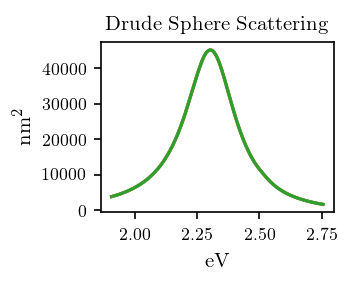

In [10]:
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'disk_simulations'
    )

sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'DrudeSphere80nm_inWater.mat'
    ))
## Convert to eV and plot spectra 
hw = 1240/sphere_spec['enei'][0]
spec = sphere_spec['sca']

plt.figure(figsize=(2,1.5), dpi=150)
for i, spectrum in enumerate(spec.T):
    plt.plot(hw, spectrum)
plt.xlabel('eV')
plt.ylabel('$\mathrm{nm}^2$')
plt.title('Drude Sphere Scattering')

array([9.82335326e+00, 9.06705560e+00, 3.34860149e-02, 4.12504947e+01,
       4.48099012e-01, 1.24956576e+01, 1.28065264e+00])

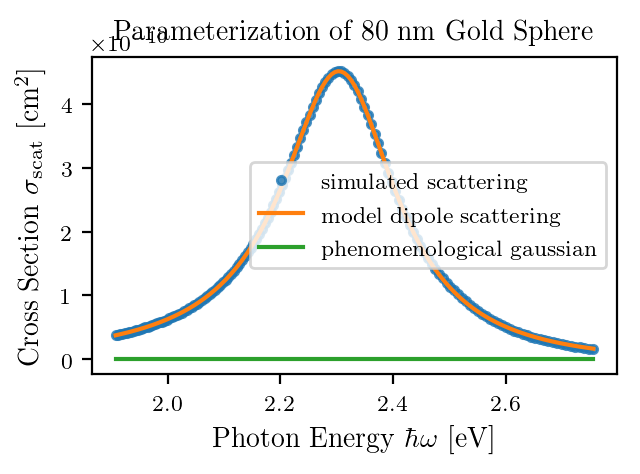

In [13]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
    .5,
    4,
    2,
#     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

def gau_cost_func(_p, *_a):
#     print(_a[0])
    return spit.hiengau_cost_func(_p, 
        model_cross_section=cp.sigma_scat_Mie_sphere, 
        *_a,)

result=opt.least_squares(
    gau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(eneis, *result['x'][:4],
    model_cross_section=cp.sigma_scat_Mie_sphere)
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='simulated scattering', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole scattering', ls='-')


fit_gauss = (
    result['x'][4]
    *
    np.exp(
        -(result['x'][5]-eneis)**2.
        /
        result['x'][6]**2.
        )*1E-10
    )
plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'Parameterization of 80 nm Gold Sphere')
plt.legend()

result['x']

array([1.30752893e+01, 1.03788711e+01, 3.84087654e-02, 4.03368752e+01])

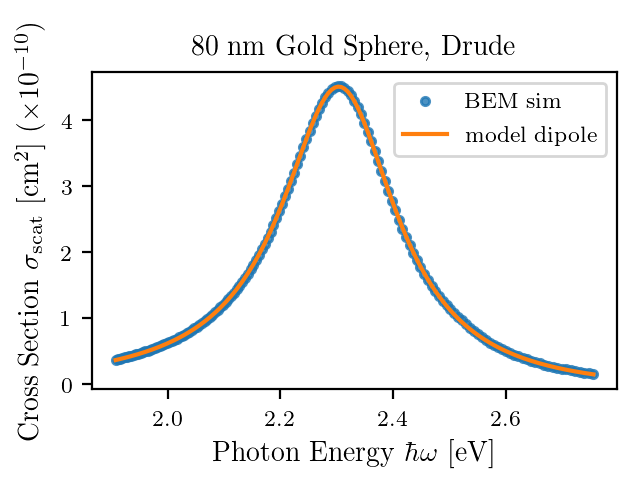

In [15]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sphere_spec['enei'][0, :]
spec = sphere_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_dip_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(eneis, *result['x'],
                                model_cross_section=cp.sigma_scat_ret_sphere)
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='BEM sim', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'80 nm Gold Sphere, Drude')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")
result['x']

In [16]:
import scipy.io as sio
path_to_sim = (
    "/Users/chair/Documents/MATLAB/sphere_dip_spectrum/")
sca_spec = sio.loadmat(os.path.join(path_to_sim, "sph_scat_spec.mat"))

array([16.76034952, 10.95916123,  0.23557438, 40.3941368 ])

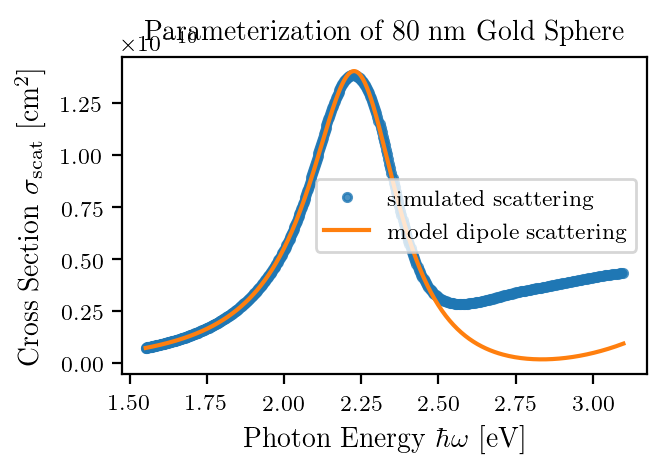

In [20]:
params0=np.array([
    13.99604932, 10.05123876,  0.28443696, 36.1993746,
#     .5,
#     4,
#     2,
# #     0.95
    ])

eneis = 1240/sca_spec['enei'][0, :]
spec = sca_spec['sca'].T[0, :]

high_enei_cutoff = 2.5

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    spit.sphere_dip_cost_fun, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
#     )
#     bounds=(
#         [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
#         [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
#         )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = spit.sphere_fit_fun(eneis, *result['x'],
                                model_cross_section=cp.sigma_scat_ret_sphere)
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = spit.sphere(args[0], *higher_damp)

data = spec*(spit.cm_per_nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='simulated scattering', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole scattering', ls='-')


# fit_gauss = (
#     result['x'][4]
#     *
#     np.exp(
#         -(result['x'][5]-eneis)**2.
#         /
#         result['x'][6]**2.
#         )*1E-10
#     )
# plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'Parameterization of 80 nm Gold Sphere')
plt.legend()

result['x']

In [21]:
eneis[np.argmax(fit_result[-1::-1])]

1.9288029925187031

In [22]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

AttributeError: 'SimulatedExperiment' object has no attribute 'alpha1_diag_dyad'

In [2]:
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# fit_inst.plot_fit_results_as_quiver_map(sim_inst)   

NameError: name 'fit' is not defined

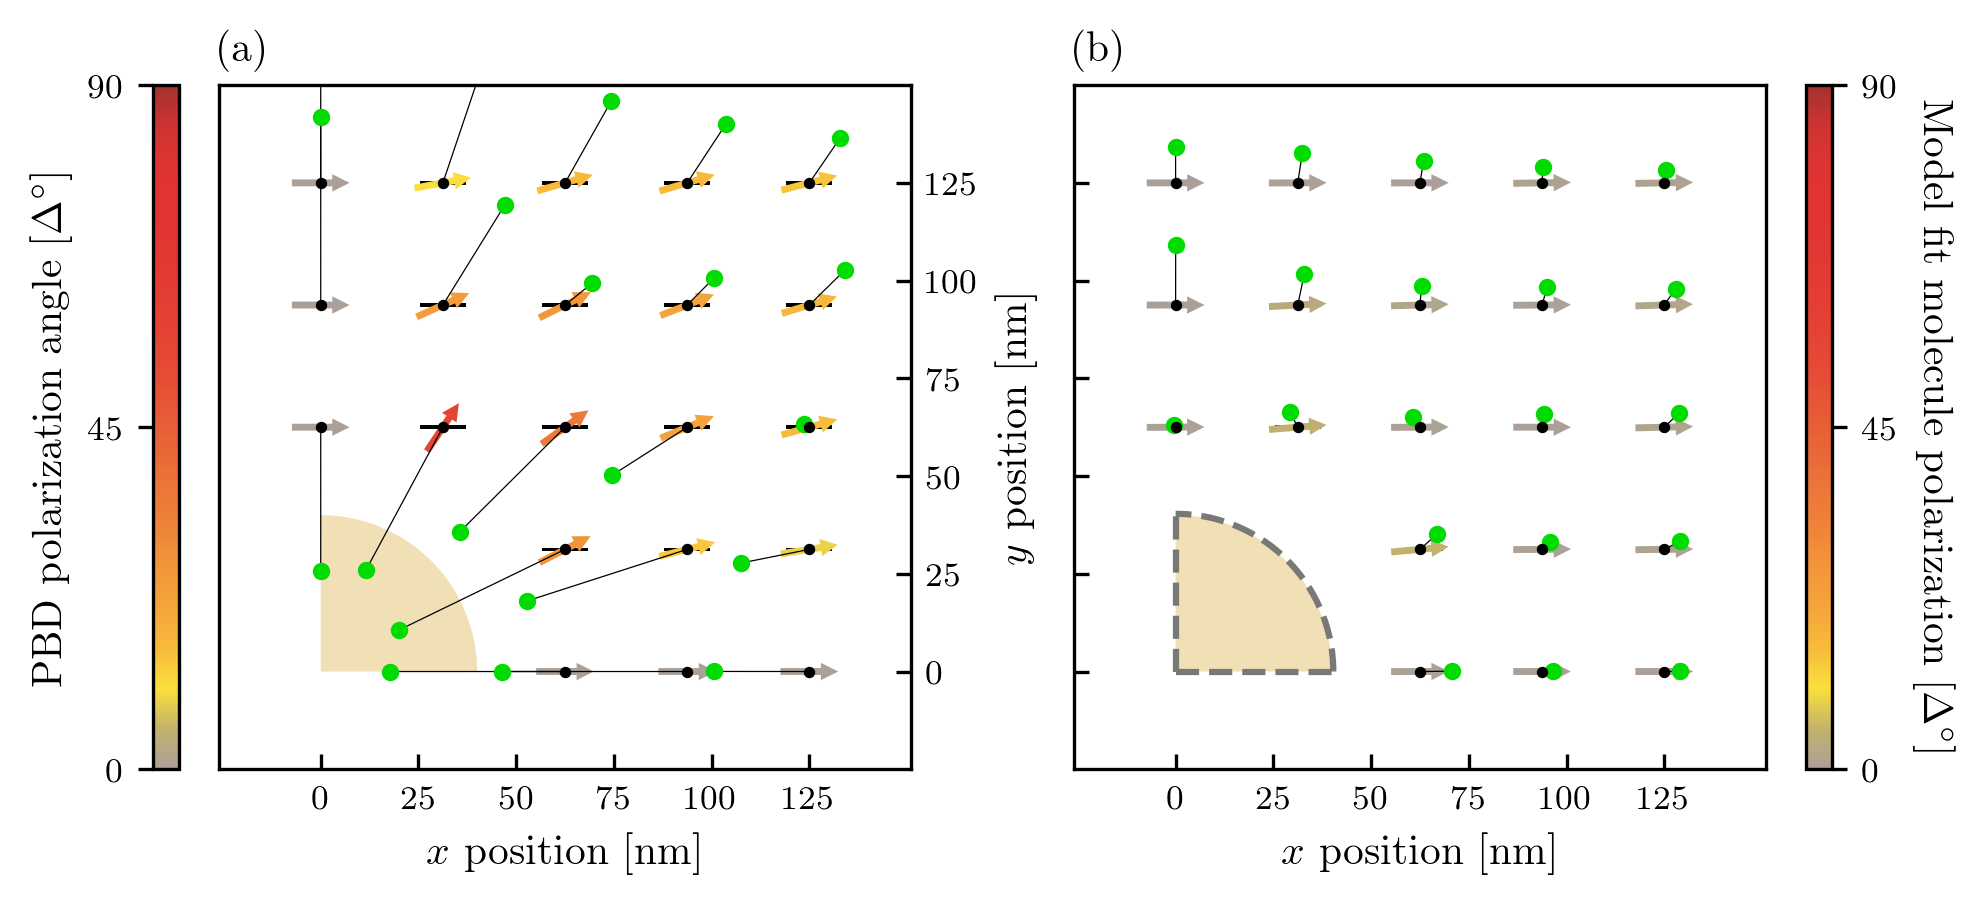

In [34]:
axs, fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [21]:
og_gau_cents = sim_inst.appar_cents

In [123]:
og_gau_cents

array([[-6.22089389e-03, -8.63537702e-03, -7.08199489e-03,
         1.16123924e+01,  4.71539930e+01,  4.11468454e+01,
         1.77480571e+01,  1.99144744e+01,  3.55691643e+01,
         6.95110190e+01,  7.42965021e+01,  4.64090774e+01,
         5.28007441e+01,  7.44292784e+01,  1.00538531e+02,
         1.03607364e+02,  1.00677361e+02,  1.07459584e+02,
         1.23641313e+02,  1.34208757e+02,  1.32841372e+02],
       [ 2.57522552e+01,  1.41904273e+02,  1.59118114e+02,
         2.60339271e+01,  1.19457787e+02,  1.54363633e+02,
        -7.82381116e-03,  1.05647901e+01,  3.57362110e+01,
         9.93872897e+01,  1.45886978e+02, -2.28427405e-03,
         1.80574413e+01,  5.01486941e+01,  1.00611760e+02,
         1.39989021e+02,  1.81483775e-02,  2.77313771e+01,
         6.33763522e+01,  1.02807181e+02,  1.36433965e+02]])

In [26]:
fit_inst.model_fit_results[:,2]

array([[-3.79446016e-01,  6.31216977e+01,  7.24790158e-03],
       [ 1.58114838e-02,  1.09134497e+02,  4.24982069e-04],
       [-2.75243763e-03,  1.34130023e+02,  5.26723937e-04],
       [ 2.93192884e+01,  6.62682416e+01,  7.88541558e-02],
       [ 3.29342190e+01,  1.01792303e+02,  5.41232827e-02],
       [ 3.24200002e+01,  1.32723982e+02,  4.67618907e-03],
       [ 7.07803978e+01,  8.44672663e-02,  4.41251938e-03],
       [ 6.67919367e+01,  3.50785899e+01,  9.27508516e-02],
       [ 6.07286290e+01,  6.51238565e+01,  5.66137521e-03],
       [ 6.29237656e+01,  9.87222261e+01,  2.70297403e-02],
       [ 6.34351084e+01,  1.30504289e+02,  2.76476680e-03],
       [ 9.66093292e+01,  1.81623336e-02,  1.07848640e-03],
       [ 9.57527456e+01,  3.31659123e+01,  8.46334790e-03],
       [ 9.41546488e+01,  6.58348011e+01,  1.93248140e-04],
       [ 9.50474161e+01,  9.84121141e+01,  9.28629166e-03],
       [ 9.39398866e+01,  1.29099740e+02,  1.63610087e-02],
       [ 1.29120191e+02,  1.13037440e-02

## Higher res simulation

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


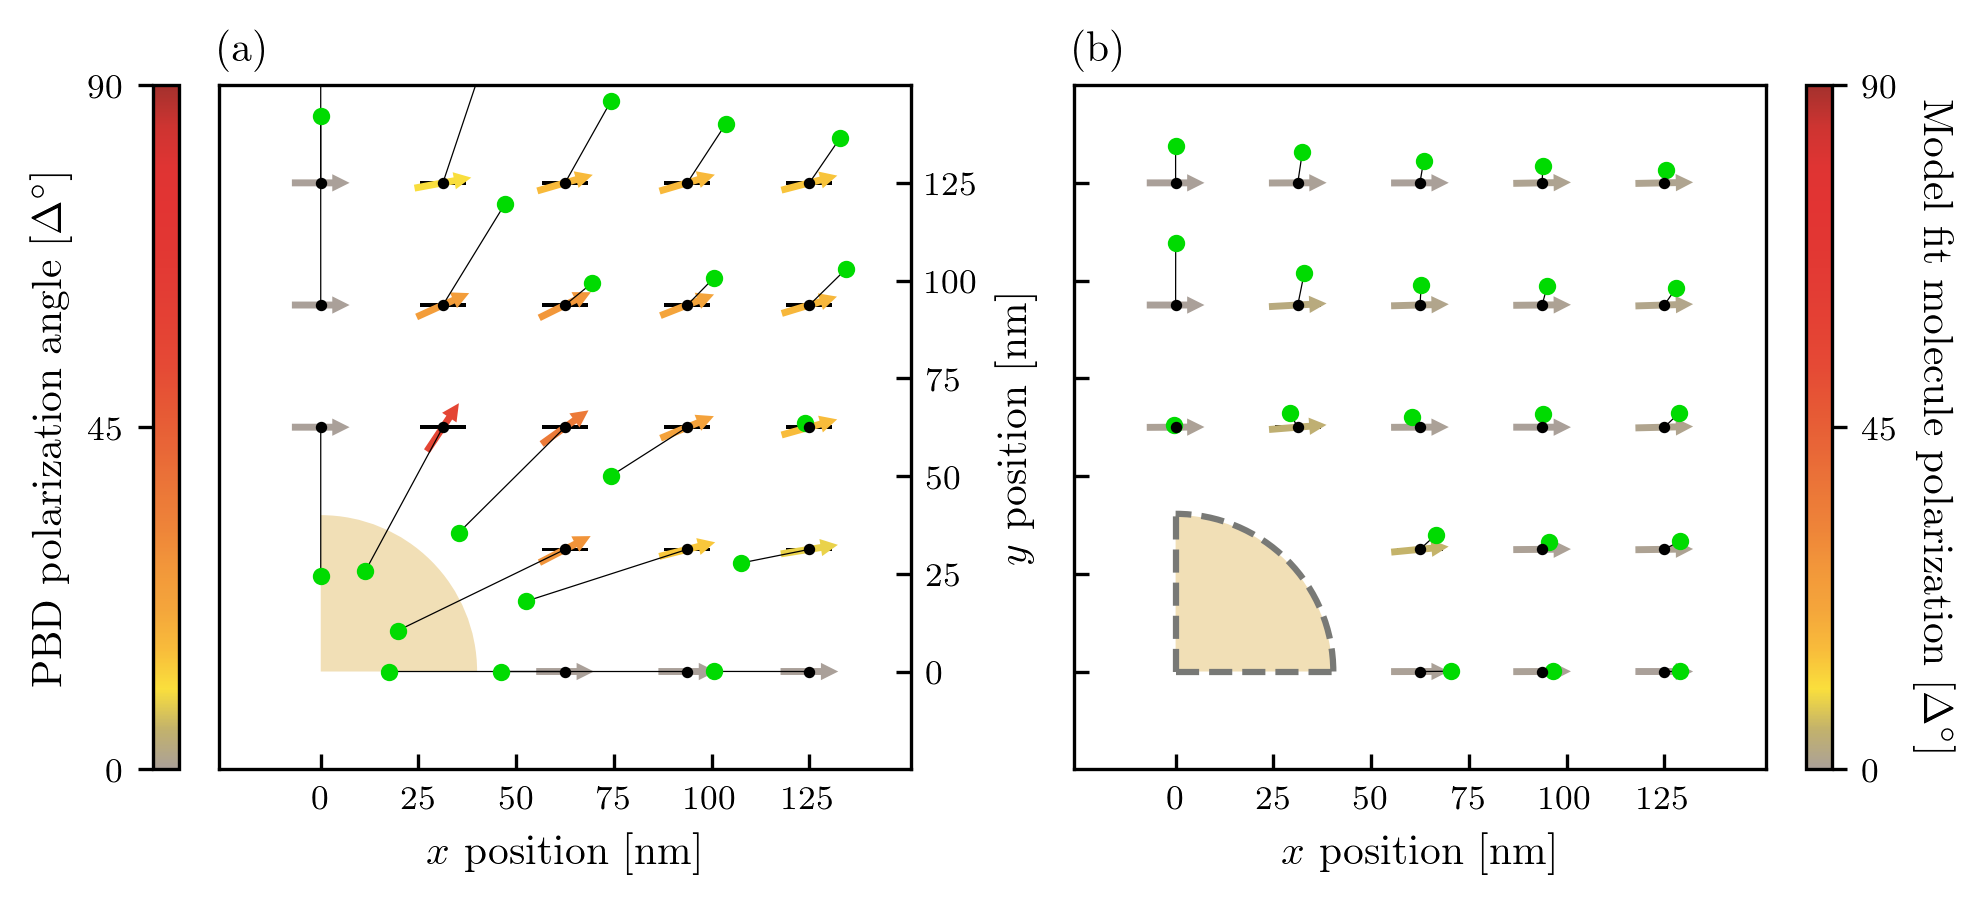

In [8]:

sim_inst_hr = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeHighDisc_NoSub_dipDrive_E')
sim_inst_hr.trial_images = sim_inst_hr.calculate_BEM_fields()

fit_inst_hr = fit.FitModelToData(
    sim_inst_hr.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit = fit_inst_hr.fit_model_to_image_data(
    check_ini=True)

fig5 = bem.fig5(sim_inst_hr, fit_inst_hr, draw_quadrant=True)

And even higher (1024)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


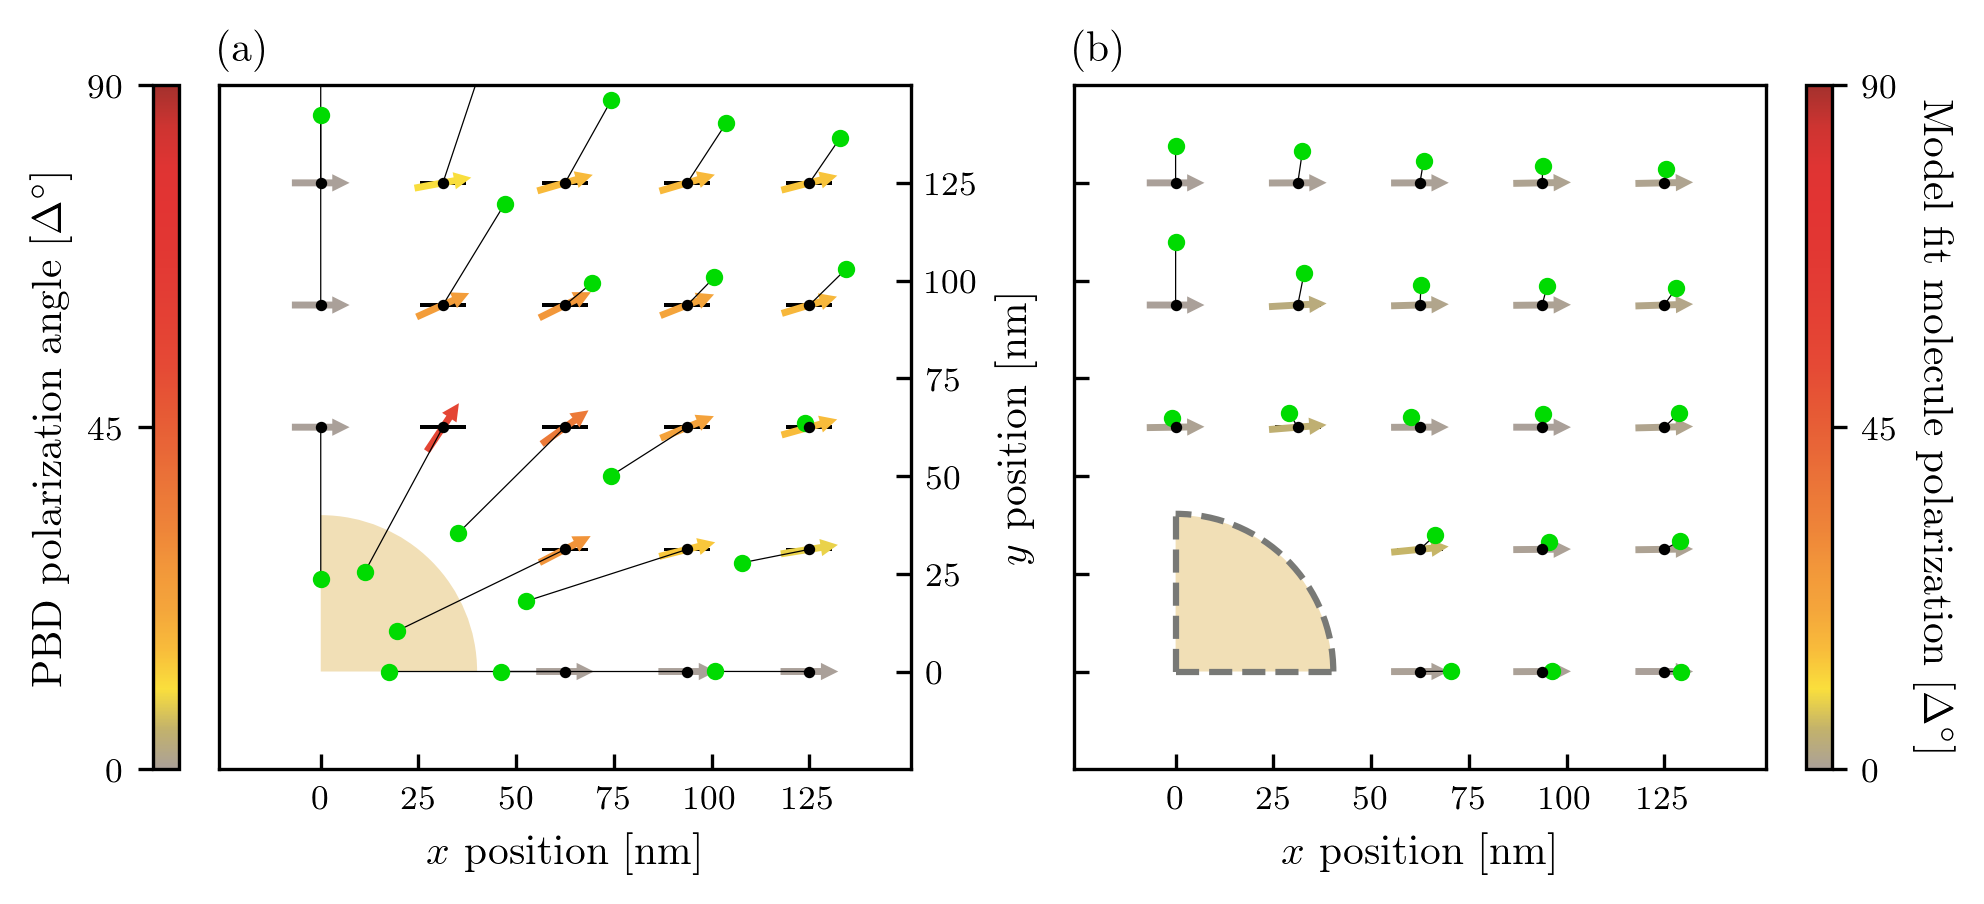

In [9]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_hd = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeHigherDisc_NoSub_dipDrive_E')
sim_inst_hd.trial_images = sim_inst_hd.calculate_BEM_fields()

fit_inst_hd = fit.FitModelToData(
    sim_inst_hd.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_hd = fit_inst_hd.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_hd.plot_fit_results_as_quiver_map(sim_inst_hd)   
fig5_HD = bem.fig5(sim_inst_hd, fit_inst_hd, draw_quadrant=True)

Drop down to 144 surface elements and see how that goes.

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


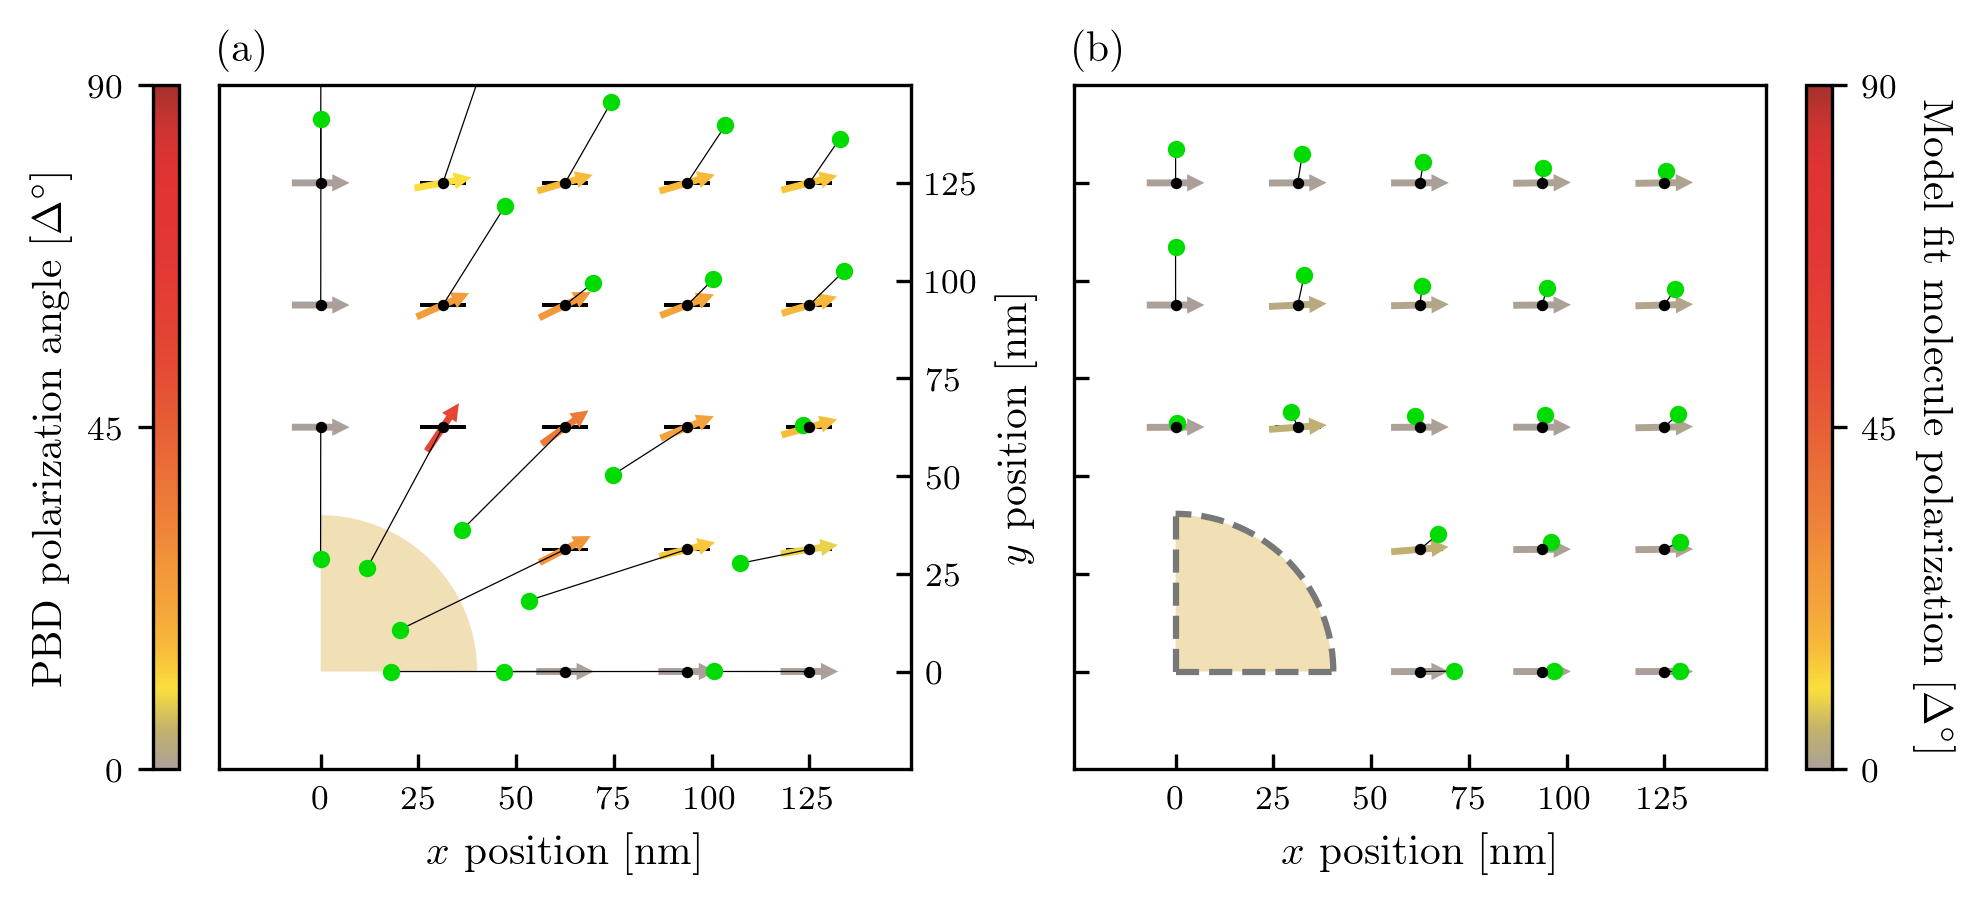

In [10]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_ld = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeLowDisc_NoSub_dipDrive_E')
sim_inst_ld.trial_images = sim_inst_ld.calculate_BEM_fields()

fit_inst_ld = fit.FitModelToData(
    sim_inst_ld.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_ld = fit_inst_ld.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_ld.plot_fit_results_as_quiver_map(sim_inst_ld)   
fig5_HD = bem.fig5(sim_inst_ld, fit_inst_ld, draw_quadrant=True)

And way down to 30 surface elements. Not convinced anything is changing. 

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


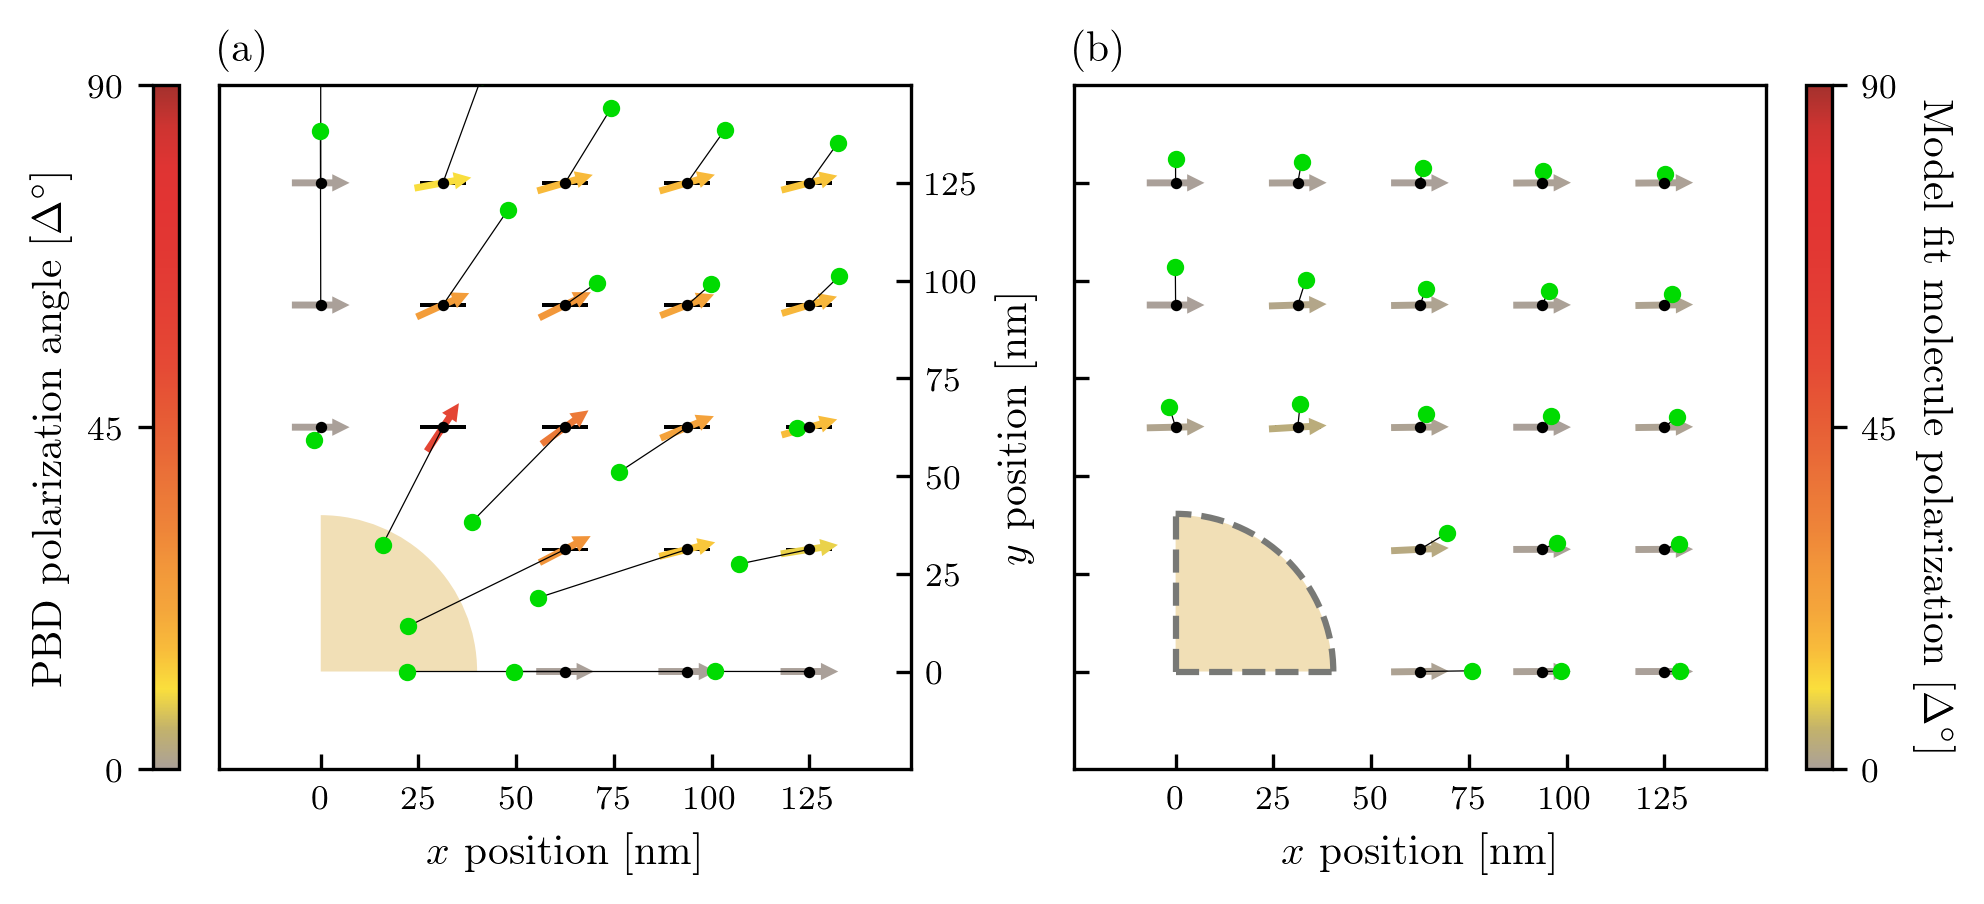

In [11]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_lld = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeLowLowDisc_NoSub_dipDrive_E')
sim_inst_lld.trial_images = sim_inst_lld.calculate_BEM_fields()

fit_inst_lld = fit.FitModelToData(
    sim_inst_lld.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_lld = fit_inst_lld.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_lld.plot_fit_results_as_quiver_map(sim_inst_lld)   
fig5_HD = bem.fig5(sim_inst_lld, fit_inst_lld, draw_quadrant=True)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


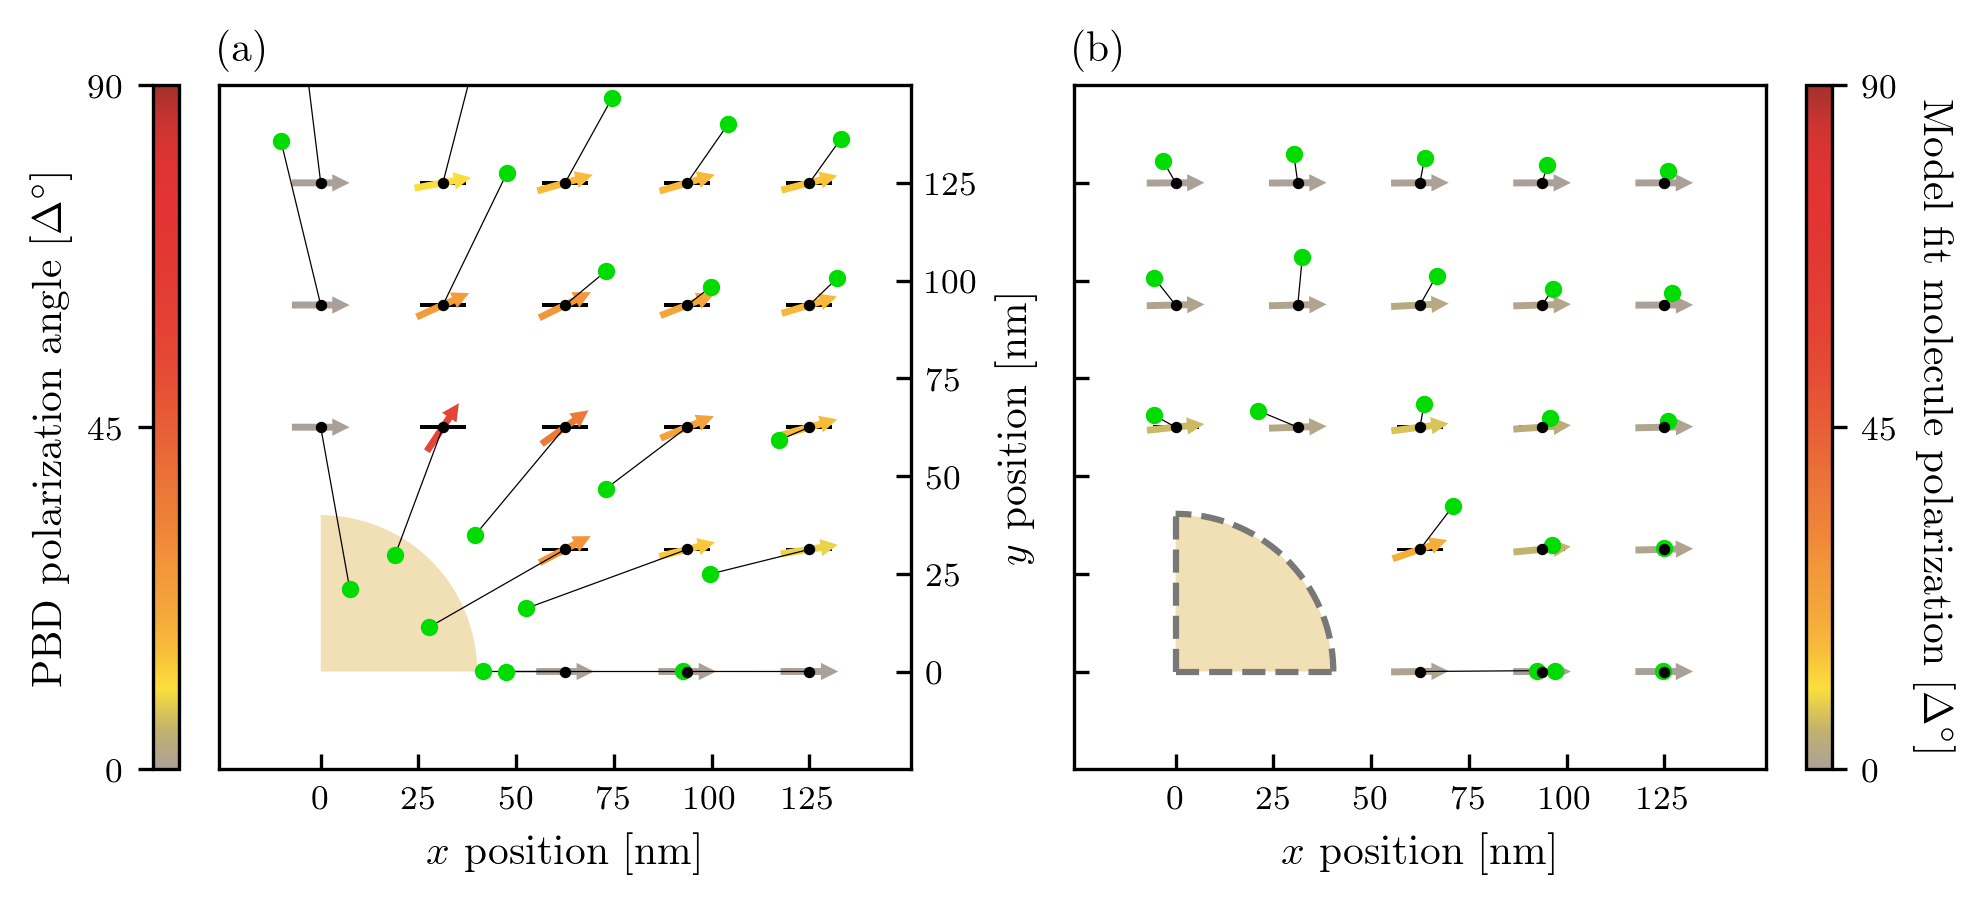

In [12]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_sh = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrudeTestShift_NoSub_dipDrive_E')
sim_inst_sh.trial_images = sim_inst_sh.calculate_BEM_fields()

fit_inst_sh = fit.FitModelToData(
    sim_inst_sh.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_sh = fit_inst_sh.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_sh.plot_fit_results_as_quiver_map(sim_inst_sh)   
fig5_HD = bem.fig5(sim_inst_sh, fit_inst_sh, draw_quadrant=True)

### Changing height of molecule

In [17]:
sph_sub_locations = locations - np.array([[0, 0, 40]])
sph_sub_locations


array([[  0.  ,   0.  , -40.  ],
       [  0.  ,  31.25, -40.  ],
       [  0.  ,  62.5 , -40.  ],
       [  0.  ,  93.75, -40.  ],
       [  0.  , 125.  , -40.  ],
       [ 31.25,   0.  , -40.  ],
       [ 31.25,  31.25, -40.  ],
       [ 31.25,  62.5 , -40.  ],
       [ 31.25,  93.75, -40.  ],
       [ 31.25, 125.  , -40.  ],
       [ 62.5 ,   0.  , -40.  ],
       [ 62.5 ,  31.25, -40.  ],
       [ 62.5 ,  62.5 , -40.  ],
       [ 62.5 ,  93.75, -40.  ],
       [ 62.5 , 125.  , -40.  ],
       [ 93.75,   0.  , -40.  ],
       [ 93.75,  31.25, -40.  ],
       [ 93.75,  62.5 , -40.  ],
       [ 93.75,  93.75, -40.  ],
       [ 93.75, 125.  , -40.  ],
       [125.  ,   0.  , -40.  ],
       [125.  ,  31.25, -40.  ],
       [125.  ,  62.5 , -40.  ],
       [125.  ,  93.75, -40.  ],
       [125.  , 125.  , -40.  ]])

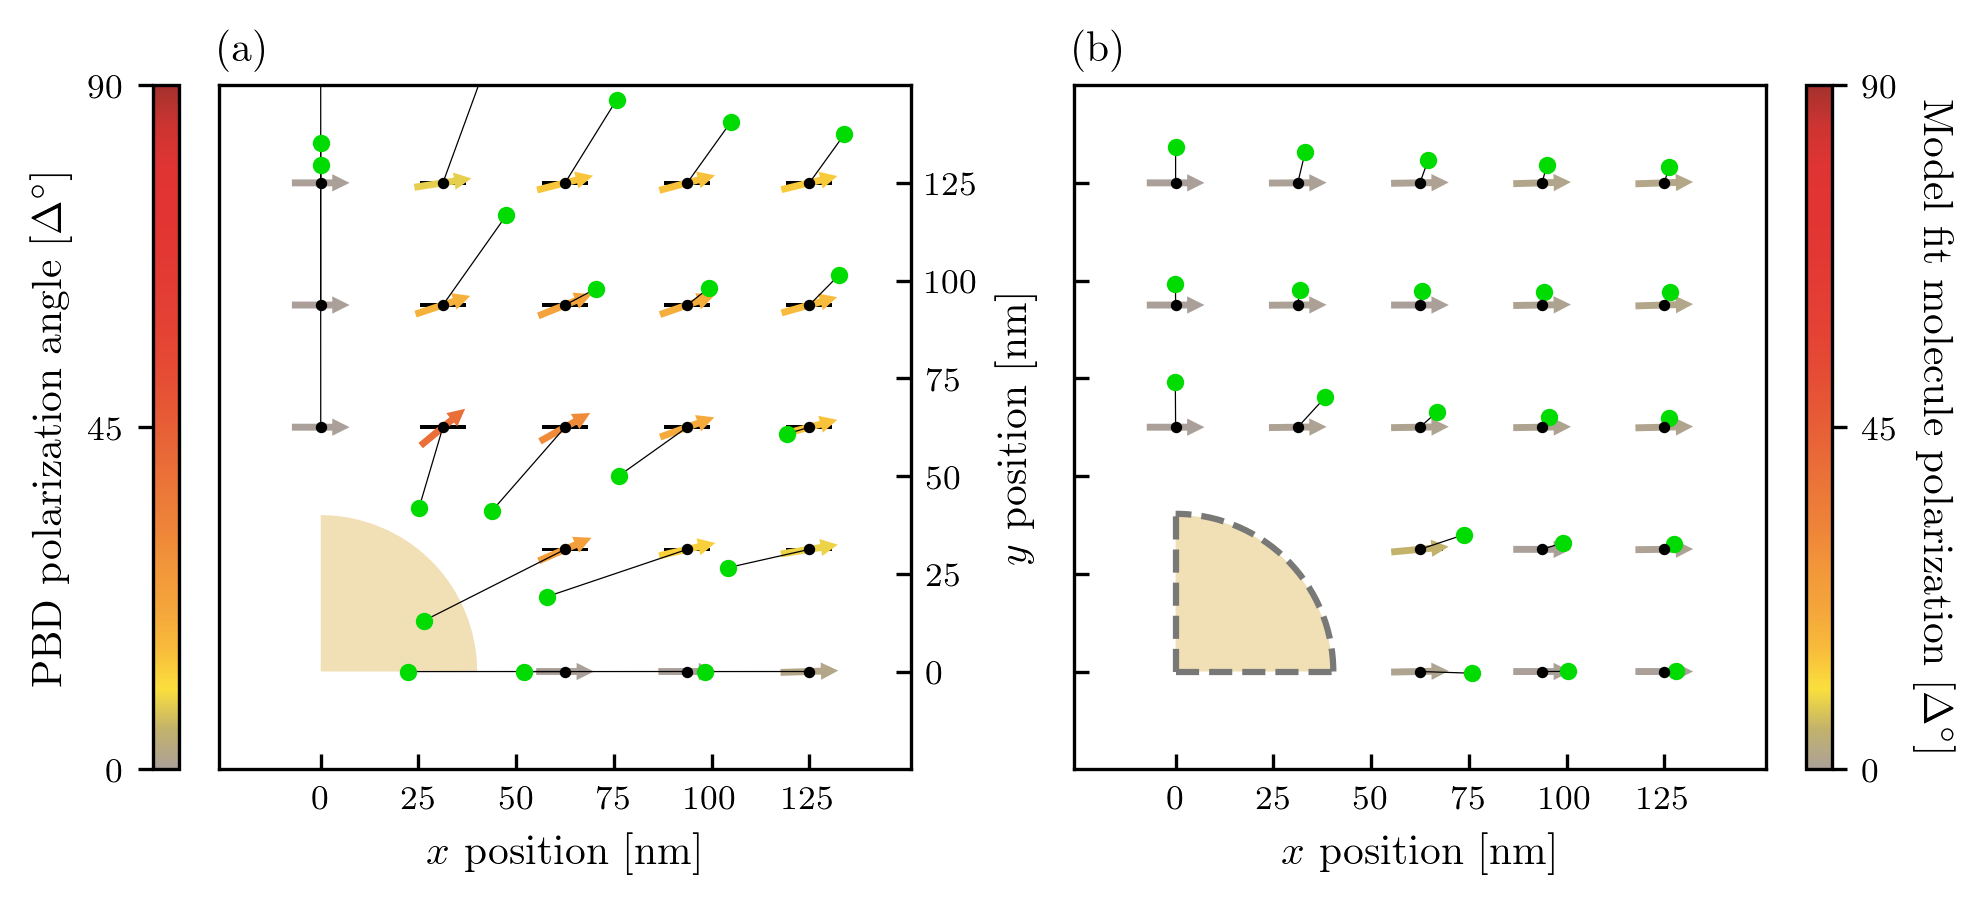

In [19]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_ms = bem.SimulatedExperiment(
    sph_sub_locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst_ms.trial_images = sim_inst_ms.calculate_BEM_fields()

fit_inst_ms = fit.FitModelToData(
    sim_inst_ms.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude'
    )
the_fit_ms = fit_inst_ms.fit_model_to_image_data(
    check_ini=True)

# ## Plot fit results
# fit_inst_ms.plot_fit_results_as_quiver_map(sim_inst_ms)   
fig5_ms = bem.fig5(sim_inst_ms, fit_inst_ms, draw_quadrant=True)

In [121]:
def connectpoints( cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1, ls='k-'):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax is None:
        plt.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)
    else:
        ax.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)

def scatter_prevCents_wLine(
    self,
    ax,
    x_mol_loc,
    y_mol_loc,
    est_locs,
    ):
    
    if est_locs == 'gauss':
        x_plot, y_plot = og_gau_cents

    elif est_locs == 'model':
        x_plot, y_plot = fit_inst.model_fit_results[:,:2].T
    
    for i in np.arange(x_plot.shape[0]):
        connectpoints(
            cen_x=x_plot,
            cen_y=y_plot,
            mol_x=x_mol_loc,
            mol_y=y_mol_loc,
            p=i,
            ax=ax,
            zorder=1,
            ls='k--'
            )
    localization_handle = ax.scatter(
        x_plot,
        y_plot,
        s=10,
        alpha=.5,
#         c=['C2'],
        zorder=2,
        facecolors='none', edgecolors='C4' 
        )
    return ax

In [118]:
# def loc_map_legend(ax, loc_label='fit localization'):
#         legend_elements = [
#             mpl.lines.Line2D(
#                 [0], [0],
#                 marker='o',
#                 color='w',
#                 label=loc_label,
#                 markerfacecolor=fit.PlottableDipoles.a_shade_of_green,
#                 markersize=10
#                 ),
#             mpl.lines.Line2D(
#                 [0], [0],
#                 marker='o',
#                 color='w',
#                 label='molecule location',
#                 markerfacecolor='black',
#                 markersize=8
#                 ),
#             ]

#         ax.legend(
#             handles=legend_elements,
#             loc='upper left',
#             bbox_to_anchor=(-.20,1.11),
#     #         ncol=2, mode="expand",
#             fontsize=8,
#             framealpha=1,
#     #         loc=1
#             )

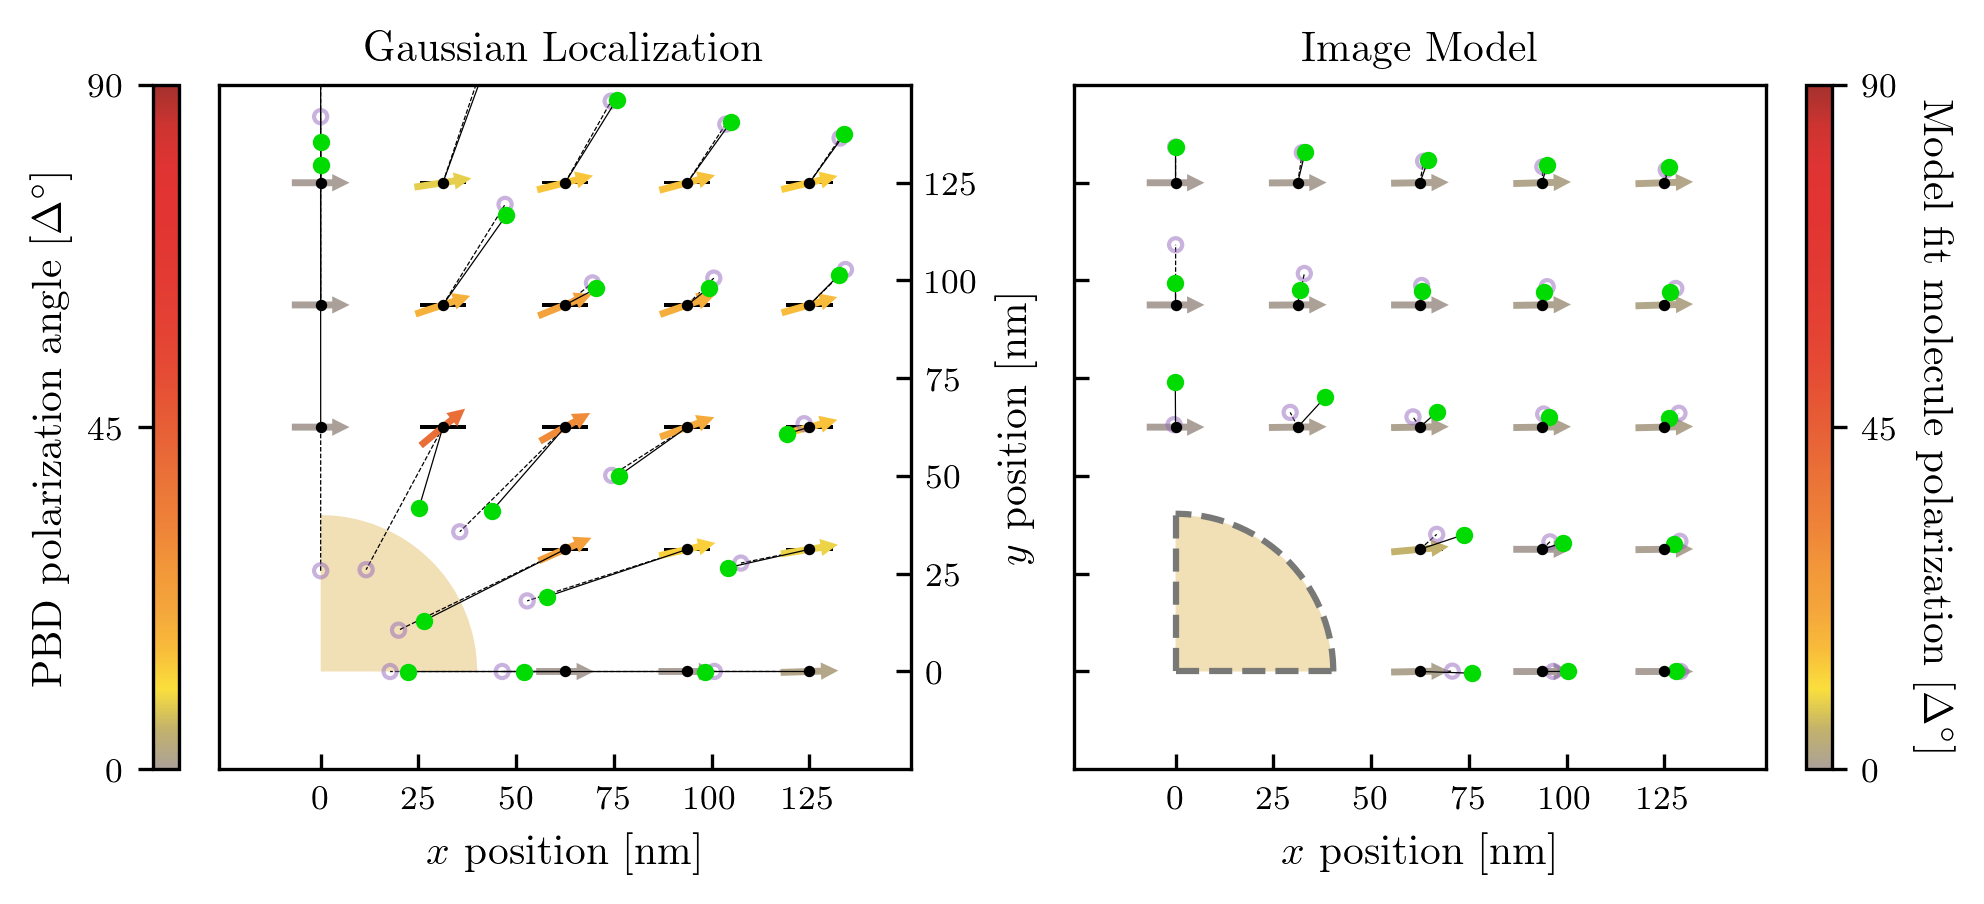

In [122]:
axs, fig5_ms = bem.fig5(
    sim_inst_ms, 
    fit_inst_ms, 
    draw_quadrant=True, 
    show_ax_labels=True,
#     show_legend=True
    )

scatter_prevCents_wLine(
    fit_inst_ms,
    axs[1],
    sim_inst_ms.mol_locations[:,0],
    sim_inst_ms.mol_locations[:,1],
    est_locs='gauss'
    )

scatter_prevCents_wLine(
    fit_inst_ms,
    axs[2],
    sim_inst_ms.mol_locations[:,0],
    sim_inst_ms.mol_locations[:,1],
    est_locs='model'
    )

# loc_map_legend(axs[2], loc_label='fit localization')

## lower NA and shift mol down. 

starting Matlab...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields

 initial guess for molecule 0 location: (-0.04227499668112695,129

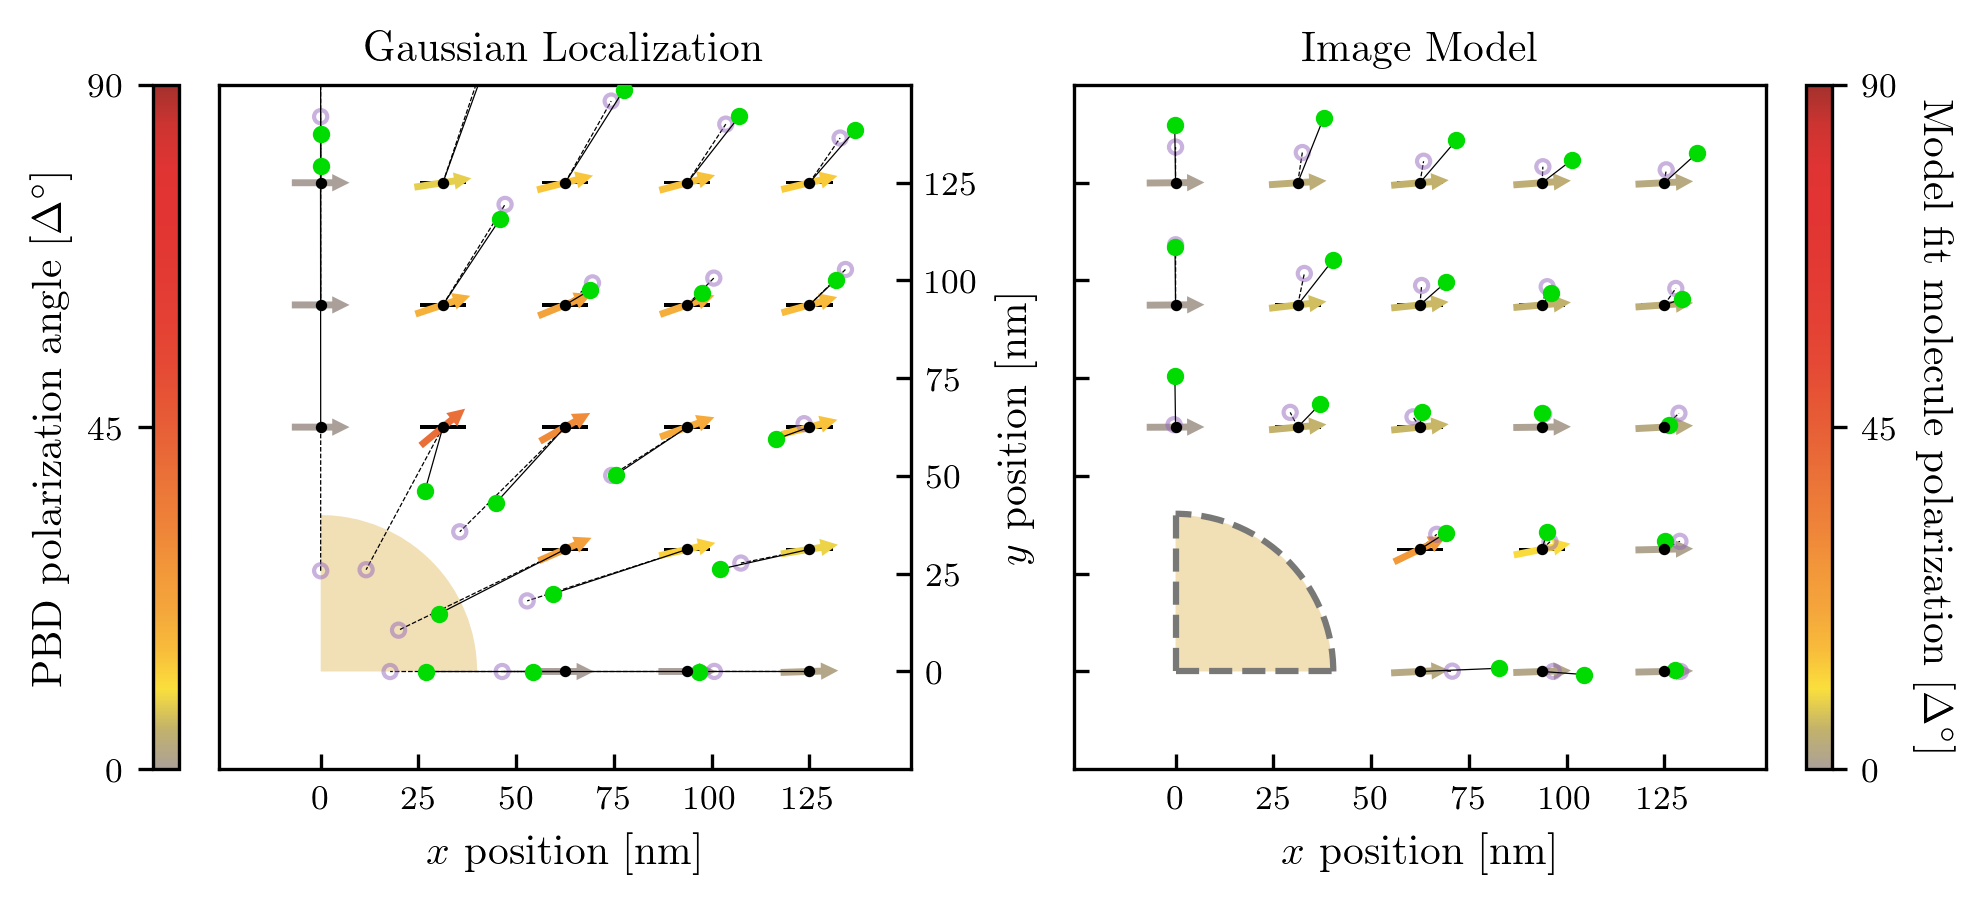

In [124]:
# locations, angles = fit.fixed_ori_mol_placement(
#     mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_naoof = bem.SimulatedExperiment(
    sph_sub_locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_NApt92',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst_naoof.trial_images = sim_inst_naoof.calculate_BEM_fields()

fit_inst_naoof = fit.FitModelToData(
    sim_inst_naoof.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_NApt92'
    )
the_fit_naoof = fit_inst_naoof.fit_model_to_image_data(
    check_ini=True)

##Build Plot
axs, fig5_naoof = bem.fig5(
    sim_inst_naoof, 
    fit_inst_naoof, 
    draw_quadrant=True, 
    show_ax_labels=True,
#     show_legend=True
    )

scatter_prevCents_wLine(
    fit_inst_naoof,
    axs[1],
    sim_inst_naoof.mol_locations[:,0],
    sim_inst_naoof.mol_locations[:,1],
    est_locs='gauss'
    )

scatter_prevCents_wLine(
    fit_inst_naoof,
    axs[2],
    sim_inst_naoof.mol_locations[:,0],
    sim_inst_naoof.mol_locations[:,1],
    est_locs='model'
    )

# loc_map_legend(axs[2], loc_label='fit localization')

NameError: name 'sim_inst' is not defined